<a href="https://colab.research.google.com/github/zilioalberto/N1---MachineLearning/blob/main/N1_Machine_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##N1 - Machiine Learning - Comite classificador
##Alunos:
##Alberto Zilio
##Lucas Carvalho Esteffens
##Roni Pereira

##Data Set Escolhido:
##Previsão de Fluxo de Tráfego
#https://archive.ics.uci.edu/dataset/608/traffic+flow+forecasting


In [22]:
#Download do dataset

# URL raw do arquivo no seu repo
RAW_URL = "https://raw.githubusercontent.com/zilioalberto/N1---MachineLearning/main/traffic_dataset.mat"

# Download do arquivo para o ambiente do Colab
!curl -L -o traffic_dataset.mat "$RAW_URL"

# Conferir se baixou
!ls -lh traffic_dataset.mat


# Verificando o formato: "MATLAB 5.0 MAT-file" (v7 até v7.2) ou "\x89HDF" (v7.3/HDF5)
with open("traffic_dataset.mat", "rb") as f:
    head = f.read(16)
print(head)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4298k  100 4298k    0     0  12.6M      0 --:--:-- --:--:-- --:--:-- 12.6M
-rw-r--r-- 1 root root 4.2M Sep 14 21:16 traffic_dataset.mat
b'MATLAB 5.0 MAT-f'


In [23]:
#Importar as bibliotecas:

import numpy as np
import scipy.io as sio
import scipy.sparse as sp


In [24]:
#Carregar o dataset

data = sio.loadmat("traffic_dataset.mat")

# Extrai as variáveis principais
tra_X_tr = data["tra_X_tr"]
tra_Y_tr = data["tra_Y_tr"]
tra_X_te = data["tra_X_te"]
tra_Y_te = data["tra_Y_te"]
tra_adj  = data.get("tra_adj_mat", None)


In [25]:
#Normalizar os dados

#Transformar tra_X_tr / tra_X_te em formato (T, S, F)

#T = número de instantes no tempo

#S = número de sensores (36)

#F = número de features (48)


def X_to_TSF(X):
    """Converte array (1,T) de cells (S,F) em ndarray (T,S,F)."""
    T = X.shape[1]
    sample0 = to_dense(X[0,0])
    S, F = sample0.shape
    out = np.empty((T, S, F), dtype=float)
    for t in range(T):
        out[t] = to_dense(X[0,t])
    return out

def Y_to_ST(Y):
    """Garante formato (S,T)"""
    Yd = to_dense(Y)
    if Yd.shape[0] == 36:
        return Yd
    if Yd.shape[1] == 36:
        return Yd.T
    raise ValueError(f"Formato inesperado para Y: {Yd.shape}")

# Normalizar
Xtr = X_to_TSF(tra_X_tr)
Ytr = Y_to_ST(tra_Y_tr)
Xte = X_to_TSF(tra_X_te)
Yte = Y_to_ST(tra_Y_te)

print("Xtr:", Xtr.shape, "| Ytr:", Ytr.shape)
print("Xte:", Xte.shape, "| Yte:", Yte.shape)


Xtr: (1261, 36, 48) | Ytr: (36, 1261)
Xte: (840, 36, 48) | Yte: (36, 840)


In [26]:
#Empilhar em formato tabular (samples × features)

#Cada linha = um sensor em um instante de tempo.
#Assim temos o dataset pronto para ML:

def stack_TS(X_ts, Y_st):
    T, S, F = X_ts.shape
    X = X_ts.reshape(T*S, F)
    y = Y_st.T.reshape(T*S)
    return X, y

X_tr, y_tr = stack_TS(Xtr, Ytr)
X_te, y_te = stack_TS(Xte, Yte)

print("Treino:", X_tr.shape, y_tr.shape)
print("Teste:", X_te.shape, y_te.shape)


Treino: (45396, 48) (45396,)
Teste: (30240, 48) (30240,)


In [27]:
#Unificar em um único dataset, já que originalmente está dividido em 60% de aprendizado e 40% de teste
X_all = np.vstack([X_tr, X_te])
y_all = np.hstack([y_tr, y_te])

print("Dataset unificado:", X_all.shape, y_all.shape)

Dataset unificado: (75636, 48) (75636,)


In [28]:
# === AMOSTRA DO DATASET UNIFICADO (tabular) ===

# 1) Empilhar treino e teste (se ainda não fez)
def stack_TS(X_ts, Y_st):
    T, S, F = X_ts.shape
    X = X_ts.reshape(T*S, F)
    y = Y_st.T.reshape(T*S)
    return X, y

X_tr, y_tr = stack_TS(Xtr, Ytr)
X_te, y_te = stack_TS(Xte, Yte)

X_all = np.vstack([X_tr, X_te])     # (75636, 48)
y_all = np.hstack([y_tr, y_te])     # (75636,)

# 2) Reconstruir índice de sensor e tempo para o dataset empilhado
SENSORS = 36
def idx_to_sensor_time(idx, sensors=SENSORS):
    t = idx // sensors  # índice temporal
    s = idx % sensors   # id do sensor
    return s, t

idxs = np.arange(X_all.shape[0])
sensor_ids = idxs % SENSORS
t_indices   = idxs // SENSORS

# 3) Montar DataFrame com nomes de colunas
feat_cols = [f"f{i:02d}" for i in range(X_all.shape[1])]
df_all = pd.DataFrame(X_all, columns=feat_cols)
df_all["target_reg"] = y_all
df_all["sensor_id"]  = sensor_ids
df_all["t_index"]    = t_indices

# 4) (Opcional, para visualização) criar classes por tercis no alvo contínuo
#    Observação: isso é só para INSPEÇÃO. Para treinar/avaliar, gere os cortes a partir do CONJUNTO DE TREINO.
q1, q2 = np.quantile(y_all, [1/3, 2/3])
df_all["target_cls"] = np.where(df_all["target_reg"] <= q1, 0,
                         np.where(df_all["target_reg"] <= q2, 1, 2))

# 5) Mostrar uma amostra e algumas estatísticas
print("Formas:")
print("X_all:", X_all.shape, " | y_all:", y_all.shape)
print("\n==== HEAD(10) ====")
display(df_all.head(10))

print("\n==== AMOSTRA ALEATÓRIA (10 linhas) ====")
display(df_all.sample(10, random_state=42))

print("\n==== DESCRITIVAS (features e target_reg) ====")
display(df_all[feat_cols + ["target_reg"]].describe().T)

print("\nDistribuição de classes (target_cls):")
print(df_all["target_cls"].value_counts(normalize=True).sort_index().round(3) * 100, "%")

# 6) Exportar um CSV de amostra (500 linhas)
sample_csv = "dataset_sample_500.csv"
df_all.sample(500, random_state=123).to_csv(sample_csv, index=False)
print(f"\nArquivo de amostra salvo: {sample_csv}")


Formas:
X_all: (75636, 48)  | y_all: (75636,)

==== HEAD(10) ====


,f00,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f42,f43,f44,f45,f46,f47,target_reg,sensor_id,t_index,target_cls
0,0.092480,0.096684,0.070061,0.065857,0.078468,0.071462,0.054180,0.044372,0.054647,0.050911,...,0.0,0.0,1.0,0.0,0.0,0.0,0.050911,0,0,0
1,0.097151,0.102289,0.081738,0.076600,0.072396,0.067725,0.058851,0.066324,0.059785,0.056983,...,0.0,0.0,1.0,0.0,0.0,0.0,0.046240,1,0,0
2,0.115367,0.110696,0.105558,0.095283,0.067725,0.080336,0.062588,0.061653,0.055582,0.061653,...,0.0,0.0,1.0,0.0,0.0,0.0,0.050444,2,0,0
3,0.112097,0.102756,0.092013,0.083606,0.062121,0.070995,0.053713,0.062588,0.053713,0.066791,...,0.0,0.0,1.0,0.0,0.0,0.0,0.044839,3,0,0
4,0.127043,0.150864,0.131714,0.106025,0.099019,0.090612,0.069127,0.060719,0.060719,0.067258,...,0.0,0.0,0.0,1.0,0.0,0.0,0.044839,4,0,0
5,0.125175,0.142924,0.115834,0.091546,0.094816,0.078468,0.071929,0.053713,0.050911,0.067725,...,0.0,0.0,0.0,1.0,0.0,0.0,0.045306,5,0,0
6,0.144325,0.172816,0.134517,0.106025,0.109762,0.090612,0.078001,0.062588,0.070528,0.076133,...,0.0,0.0,0.0,1.0,0.0,0.0,0.056983,6,0,0
7,0.098552,0.106492,0.089211,0.070995,0.063989,0.047641,0.053713,0.040635,0.042971,0.041102,...,0.0,0.0,0.0,1.0,0.0,0.0,0.043438,7,0,0
8,0.149463,0.161140,0.137319,0.121906,0.126576,0.114433,0.102756,0.109295,0.098085,0.086408,...,0.0,0.0,1.0,0.0,0.0,0.0,0.083139,8,0,0
9,0.182625,0.187763,0.172816,0.159271,0.145726,0.137319,0.134517,0.141523,0.112564,0.108361,...,0.0,0.0,1.0,0.0,0.0,0.0,0.105091,9,0,0



==== AMOSTRA ALEATÓRIA (10 linhas) ====


,f00,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f42,f43,f44,f45,f46,f47,target_reg,sensor_id,t_index,target_cls
22389,0.219524,0.231667,0.256889,0.263428,0.262027,0.285848,0.313872,0.298926,0.304531,0.349837,...,0.0,1.0,0.0,0.0,0.0,1.0,0.422700,33,621,2
74087,0.478748,0.454461,0.454461,0.444185,0.398879,0.396077,0.419897,0.419430,0.387202,0.399346,...,0.0,1.0,0.0,0.0,1.0,0.0,0.438113,35,2057,2
74730,0.798225,0.762728,0.816908,0.837926,0.810836,0.781411,0.768333,0.768800,0.789351,0.802896,...,0.0,1.0,0.0,0.0,0.0,1.0,0.732835,30,2075,2
30998,0.116301,0.113498,0.091079,0.086408,0.078935,0.063055,0.049977,0.053246,0.051378,0.035030,...,0.0,0.0,1.0,0.0,0.0,0.0,0.033162,2,861,0
15071,0.298926,0.316674,0.290518,0.272770,0.263895,0.247548,0.232602,0.215787,0.240075,0.226997,...,1.0,0.0,1.0,0.0,0.0,0.0,0.218122,23,418,1
37998,0.132181,0.122373,0.120972,0.119570,0.097618,0.095750,0.097618,0.061186,0.078001,0.070995,...,0.0,0.0,0.0,1.0,0.0,0.0,0.066791,18,1055,0
67171,0.365717,0.363849,0.419897,0.468473,0.492293,0.506305,0.521252,0.570294,0.574498,0.537132,...,0.0,1.0,0.0,0.0,0.0,1.0,0.608594,31,1865,2
17513,0.063522,0.060719,0.084540,0.055582,0.065390,0.063055,0.059318,0.058384,0.049977,0.078468,...,0.0,0.0,0.0,1.0,0.0,0.0,0.066791,17,486,0
40055,0.208781,0.214386,0.223727,0.248015,0.239608,0.282111,0.284447,0.251284,0.235404,0.239141,...,1.0,0.0,1.0,0.0,0.0,0.0,0.223727,23,1112,1
69209,0.107894,0.094348,0.092947,0.078935,0.081738,0.079869,0.079869,0.094348,0.078001,0.068192,...,0.0,0.0,0.0,1.0,0.0,0.0,0.085474,17,1922,0



==== DESCRITIVAS (features e target_reg) ====


,count,mean,std,min,25%,50%,75%,max
f00,75636.0,0.310707,0.201989,0.0,0.131714,0.300327,0.451191,1.0
f01,75636.0,0.310764,0.201965,0.0,0.132181,0.300327,0.451191,1.0
f02,75636.0,0.310819,0.201940,0.0,0.132181,0.300327,0.451191,1.0
f03,75636.0,0.310876,0.201911,0.0,0.132181,0.300327,0.451191,1.0
f04,75636.0,0.310924,0.201879,0.0,0.132181,0.300327,0.451191,1.0
f05,75636.0,0.310961,0.201850,0.0,0.132532,0.300327,0.451191,1.0
f06,75636.0,0.310991,0.201825,0.0,0.132648,0.300327,0.451191,1.0
f07,75636.0,0.311025,0.201797,0.0,0.132648,0.300327,0.451191,1.0
f08,75636.0,0.311047,0.201775,0.0,0.132648,0.300327,0.451191,1.0
f09,75636.0,0.311069,0.201754,0.0,0.133115,0.300327,0.451191,1.0



Distribuição de classes (target_cls):
target_cls
0    33.4
1    33.3
2    33.3
Name: proportion, dtype: float64 %

Arquivo de amostra salvo: dataset_sample_500.csv


Xtr: (1261, 36, 48)  | Ytr: (36, 1261)
Xte: (840, 36, 48)  | Yte: (36, 840)
Empilhado -> X_tr: (45396, 48)  | y_tr: (45396,)


,f00,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f39,f40,f41,f42,f43,f44,f45,f46,f47,target_reg
0,0.092480,0.096684,0.070061,0.065857,0.078468,0.071462,0.054180,0.044372,0.054647,0.050911,...,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.050911
1,0.097151,0.102289,0.081738,0.076600,0.072396,0.067725,0.058851,0.066324,0.059785,0.056983,...,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.046240
2,0.115367,0.110696,0.105558,0.095283,0.067725,0.080336,0.062588,0.061653,0.055582,0.061653,...,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.050444
3,0.112097,0.102756,0.092013,0.083606,0.062121,0.070995,0.053713,0.062588,0.053713,0.066791,...,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.044839
4,0.127043,0.150864,0.131714,0.106025,0.099019,0.090612,0.069127,0.060719,0.060719,0.067258,...,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.044839
5,0.125175,0.142924,0.115834,0.091546,0.094816,0.078468,0.071929,0.053713,0.050911,0.067725,...,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.045306
6,0.144325,0.172816,0.134517,0.106025,0.109762,0.090612,0.078001,0.062588,0.070528,0.076133,...,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.056983
7,0.098552,0.106492,0.089211,0.070995,0.063989,0.047641,0.053713,0.040635,0.042971,0.041102,...,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.043438
8,0.149463,0.161140,0.137319,0.121906,0.126576,0.114433,0.102756,0.109295,0.098085,0.086408,...,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.083139
9,0.182625,0.187763,0.172816,0.159271,0.145726,0.137319,0.134517,0.141523,0.112564,0.108361,...,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.105091


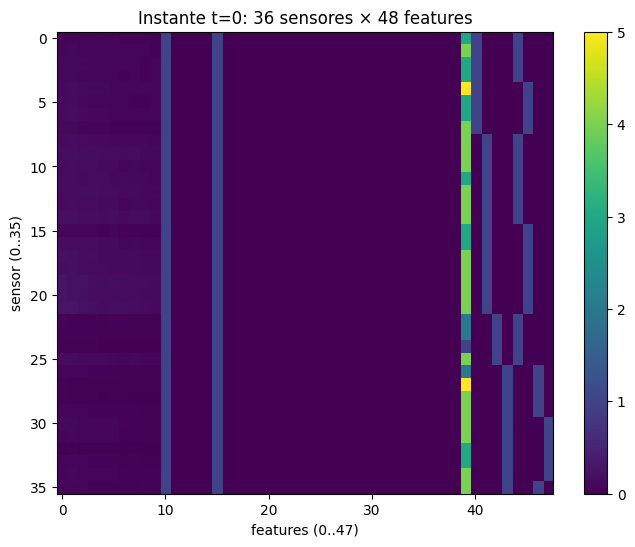

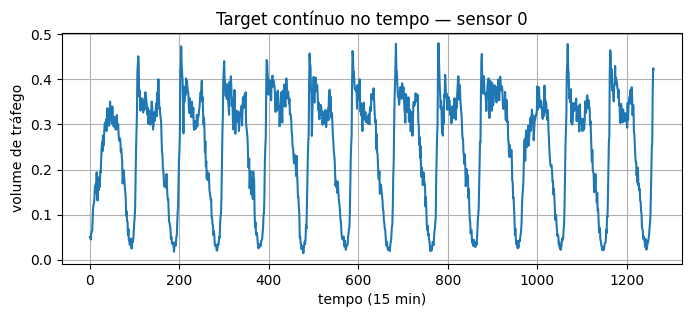

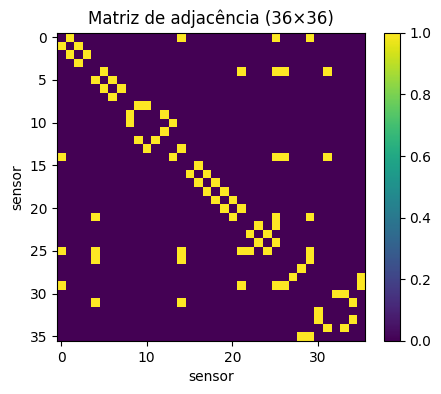

In [21]:
# === Loader robusto p/ esparsos + preview/plots ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.sparse as sp

# 1) Carregar
data = sio.loadmat("traffic_dataset.mat")
tra_X_tr = data["tra_X_tr"]; tra_Y_tr = data["tra_Y_tr"]
tra_X_te = data["tra_X_te"]; tra_Y_te = data["tra_Y_te"]
tra_adj  = data.get("tra_adj_mat", None)

def to_dense(a):
    """Converte csc/csr/coo para denso; mantém ndarray como está."""
    if sp.issparse(a):
        return a.toarray()
    # alguns loaders usam tipos próprios (csc_array); issparse já cobre
    return np.array(a)

# 2) X: (1,T) com elementos (S,F) esparsos -> (T,S,F) denso
def X_to_TSF(X):
    assert X.ndim == 2 and X.shape[0] == 1, f"Esperado (1,T), veio {X.shape}"
    T = X.shape[1]
    sample0 = to_dense(X[0,0])
    S, F = sample0.shape
    out = np.empty((T, S, F), dtype=float)
    for t in range(T):
        out[t] = to_dense(X[0, t])
    return out

# 3) Y: pode vir esparso; queremos (S,T) denso
def Y_to_ST(Y):
    Yd = to_dense(Y)
    if Yd.ndim != 2:
        raise ValueError(f"Y com ndim inesperado: {Yd.ndim}")
    S, T = Yd.shape
    if S == 36:
        return Yd
    if T == 36:   # está transposto
        return Yd.T
    raise ValueError(f"Y shape inesperado: {Yd.shape}")

Xtr = X_to_TSF(tra_X_tr)     # (T_tr, 36, 48)
Ytr = Y_to_ST(tra_Y_tr)      # (36, T_tr)
Xte = X_to_TSF(tra_X_te)     # (T_te, 36, 48)
Yte = Y_to_ST(tra_Y_te)      # (36, T_te)

print("Xtr:", Xtr.shape, " | Ytr:", Ytr.shape)
print("Xte:", Xte.shape, " | Yte:", Yte.shape)

# 4) Empilhar para pré-visualização (cada amostra = 1 sensor em 1 tempo)
def stack_TS(X_ts, Y_st):
    T, S, F = X_ts.shape
    X = X_ts.reshape(T*S, F)
    y = Y_st.T.reshape(T*S)
    return X, y

X_tr, y_tr = stack_TS(Xtr, Ytr)
X_te, y_te = stack_TS(Xte, Yte)

print("Empilhado -> X_tr:", X_tr.shape, " | y_tr:", y_tr.shape)

# 5) Mostrar primeiras linhas (empilhado)
feat_cols = [f"f{i:02d}" for i in range(X_tr.shape[1])]
df_head = pd.DataFrame(X_tr[:10], columns=feat_cols)
df_head["target_reg"] = y_tr[:10]
display(df_head)

# 6) Heatmap de um instante (36 sensores × 48 features)
t = 0
plt.figure(figsize=(8,6))
plt.imshow(Xtr[t], aspect="auto")
plt.colorbar()
plt.title(f"Instante t={t}: 36 sensores × 48 features")
plt.xlabel("features (0..47)")
plt.ylabel("sensor (0..35)")
plt.show()

# 7) Série temporal do alvo (um sensor)
sensor = 0
plt.figure(figsize=(8,3))
plt.plot(Ytr[sensor])
plt.title(f"Target contínuo no tempo — sensor {sensor}")
plt.xlabel("tempo (15 min)")
plt.ylabel("volume de tráfego")
plt.grid(True)
plt.show()

# 8) (Opcional) Ver adjacência se existir
if tra_adj is not None:
    A = to_dense(tra_adj)
    plt.figure(figsize=(5,4))
    plt.imshow(A, aspect="equal")
    plt.title("Matriz de adjacência (36×36)")
    plt.colorbar()
    plt.xlabel("sensor")
    plt.ylabel("sensor")
    plt.show()


In [ ]:
#Dataset está dividido em 60% de aprendizagem e 40% de testes
#Vamos agrupar todos os dados